In [29]:
#Importing packages, setting style for charts

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd as pt
import warnings

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [30]:
# Reading in the dataframes

movie_info    = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t') # mi
tmdb          = pd.read_csv('zippedData/tmdb.movies.csv.gz') #tmdb
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz') # mb
movie_gross   = pd.read_csv("zippedData/bom.movie_gross.csv.gz") # mg
reviews       = pd.read_csv("zippedData/rt.reviews.tsv.gz", error_bad_lines=False, sep='\t', encoding= 'unicode_escape')

# 1. Cleaning Data

In [31]:
# Adding a column that concantenates the title and release date of the movie for dataframe merging with movie_budgets dataframe
tmdb_title = tmdb['original_title']
tmdb_date = tmdb['release_date']
tmdb['title_and_year'] = tmdb_title + ' ' + tmdb_date.apply(lambda x: x[:4])

# Removing duplicates from tmdb
tmdb = tmdb.drop_duplicates(subset='id', keep='first')
tmdb = tmdb.drop_duplicates(subset='title_and_year', keep='first')

In [35]:
# Adding a matching column in movie_budgets to prepare for merge with tmdb dataframe
mb_title = movie_budgets['movie']
mb_date = movie_budgets['release_date']
movie_budgets['title_and_year'] = mb_title + ' ' + mb_date.apply(lambda x: x[-4:])

In [36]:
# Creating numeric columns to represent revenue and budget
movie_budgets['revenue'] = movie_budgets['worldwide_gross'].replace('[\$,]','', regex=True).astype(float)
movie_budgets['budget'] = movie_budgets['production_budget'].replace('[\$,]','', regex=True).astype(float)

# Removing duplicates
movie_budgets = movie_budgets.drop_duplicates(subset='title_and_year', keep='first')

In [38]:
# Merging the tmdb and movie_budgets dataframe
tmdb_n_budgets = pd.merge(movie_budgets, tmdb, how='inner', on='title_and_year')

"""
Filtering to rows that have greater than $0 in revenue. 
Research showed that many of these movies were released directly to streaming services, not theatres
"""
tmdb_n_budgets = tmdb_n_budgets.loc[tmdb_n_budgets['revenue'] != 0]
tmdb_n_budgets.head()

,id_x,release_date_x,movie,production_budget,domestic_gross,worldwide_gross,title_and_year,revenue,budget,Unnamed: 0,genre_ids,id_y,original_language,original_title,popularity,release_date_y,title,vote_average,vote_count
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",Avatar 2009,2.776345e+09,425000000.0,6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides 2011,1.045664e+09,410600000.0,2470,"[12, 28, 14]",1865,en,Pirates of the Caribbean: On Stranger Tides,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571
2,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron 2015,1.403014e+09,330600000.0,14169,"[28, 12, 878]",99861,en,Avengers: Age of Ultron,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457
3,7,"Apr 27, 2018",Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War 2018,2.048134e+09,300000000.0,23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948
4,9,"Nov 17, 2017",Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League 2017,6.559452e+08,300000000.0,20623,"[28, 12, 14, 878]",141052,en,Justice League,34.953,2017-11-17,Justice League,6.2,7510


# 2. Linear Regression

### In this section we conducted linear regression tests on the movie's budget, vote average, and revenue to see how they are related

In [40]:
budget = tmdb_n_budgets['budget']
vote_average = tmdb_n_budgets['vote_average']

model = sm.OLS(vote_average, sm.add_constant(budget))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           vote_average   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     23.58
Date:                Tue, 20 Jun 2023   Prob (F-statistic):           1.32e-06
Time:                        22:22:50   Log-Likelihood:                -1854.5
No. Observations:                1504   AIC:                             3713.
Df Residuals:                    1502   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2627      0.028    226.929      0.000       6.209       6.317
budget      1.869e-09   3.85e-10      4.856      0.000    1.11e-09    2.62e-09
==============================================================================
Omnibus:                       32.028   Durbin-Watson:                   1.849
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.793
Skew:                          -0.290   Prob(JB):                     6.21e-09
Kurtosis:                       3.516   Cond. No.                     9.24e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.24e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

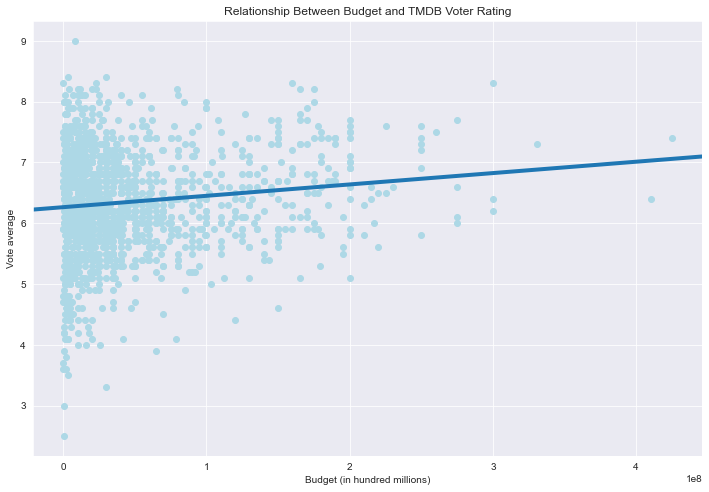

In [43]:
# Plotting the vote_average vs. budget
fig, ax=plt.subplots(figsize=(12,8))
ax.scatter(budget, vote_average, color='lightblue')
ax.set_xlabel('Budget (in hundred millions)')
ax.set_ylabel('Vote average')
ax.set_title('Relationship Between Budget and TMDB Voter Rating')
sm.graphics.abline_plot(model_results=results, ax=ax, linewidth=4);